# EDA of "ChatGPT Classification Dataset"
#### Kaggle description
We have compiled a dataset that consists of textual articles including common terminology, concepts and definitions in the field of computer science, artificial intelligence, and cyber security. This dataset consists of both human-generated text and OpenAI’s ChatGPT-generated text. Human-generated answers were collected from different computer science dictionaries and encyclopedias including “The Encyclopedia of Computer Science and Technology” and "Encyclopedia of Human-Computer Interaction". AI-generated content in our dataset was produced by simply posting questions to OpenAI’s ChatGPT and manually documenting the resulting responses. A rigorous data-cleaning process has been performed to remove unwanted Unicode characters, styling and formatting tags. To structure our dataset for binary classification, we combined both AI-generated and Human-generated answers into a single column and assigned appropriate labels to each data point (Human-generated = 0 and AI-generated = 1).

This creates our article-level dataset (article_level_data.csv) which consists of a total of 1018 articles, 509 AI-generated and 509 Human-generated. Additionally, we have divided each article into its sentences and labelled them accordingly. This is mainly to evaluate the performance of classification models and pipelines when it comes to shorter sentence-level data points. This constructs our sentence-level dataset (sentence_level_data.csv) which consists of a total of 7344 entries (4008 AI-generated and 3336 Human-generated). 

In [29]:
import pandas as pd
import re
import unicodedata
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from nltk.probability import FreqDist # This is for counting the most frequent words
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize # this is for counting the senteces
plt.style.use('ggplot')

In [2]:
data = pd.read_csv("article_level_data.csv" , index_col= False )
data.drop(columns=["Unnamed: 0"])
data.head(5)

,Unnamed: 0,article,class
0,0,NLP is a multidisciplinary field that draws fr...,0
1,1,There are a variety of emerging applications f...,0
2,2,As each new means of communication and social ...,0
3,3,"These suggestions include:, Learn about the pu...",0
4,4,In recent years there has been growing concern...,0


In [3]:
print(data.shape)
data.info()

(1018, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1018 non-null   int64 
 1   article     1018 non-null   object
 2   class       1018 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 24.0+ KB


In [4]:
# Checking missing values...
data.isna().sum()

Unnamed: 0    0
article       0
class         0
dtype: int64

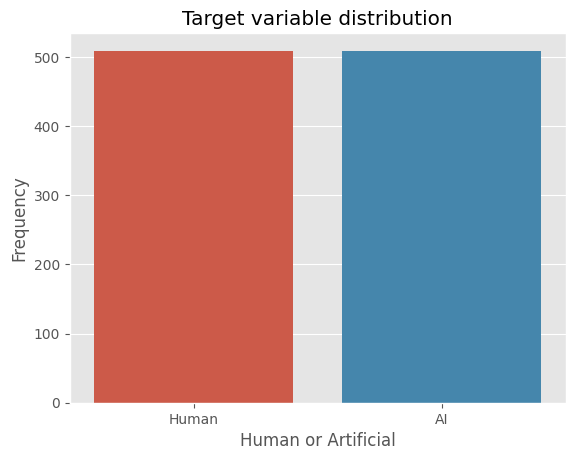

In [5]:
# Let's see the target class distribution
fig = sns.countplot(data, x = 'class')
fig.set(title = 'Target variable distribution', xlabel = 'Human or Artificial', ylabel = 'Frequency', xticklabels=['Human','AI'] )
plt.show()
# We have a very balanced dataset

# EDA --> Counts and lengths

#### Character Count

In [28]:
def article_length(text):
    return len(text)

data['length'] = data['article'].apply(article_length) 

In [7]:
print(data[data['class']==0].length.mean())
print(data[data['class']==1].length.mean())
# Not a big difference in the article's length

905.5795677799607
1124.7976424361493


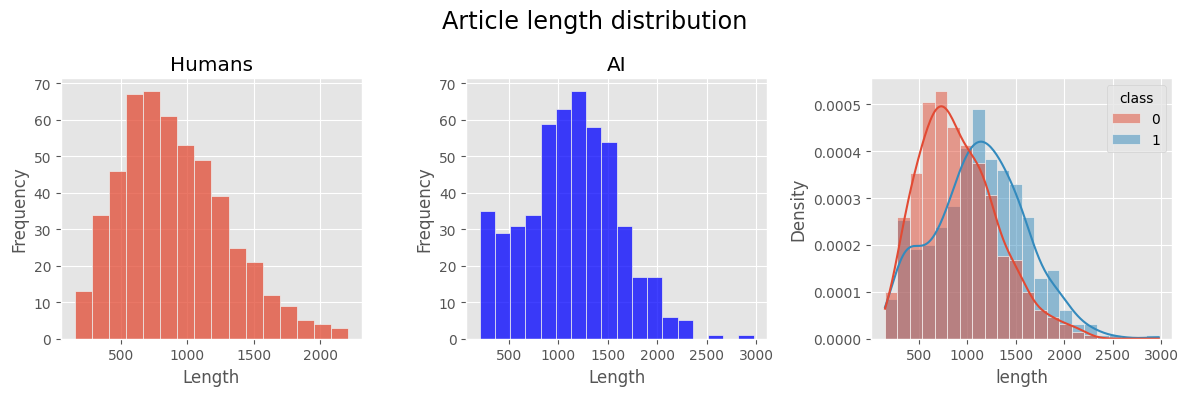

In [25]:
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['class']==0], x = 'length', ax = axes[0])
fig_dist_human.set(title = 'AI', xlabel='Length', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['class']==1], x = 'length', ax = axes[1], color = 'blue')
fig_dist_ai.set(title = 'AI', xlabel='Length', ylabel= 'Frequency')
fig.suptitle('Article length distribution', fontsize =  'xx-large')
sns.histplot(data = data, x = 'length', hue="class", kde= True, stat = 'density', ax = axes[2] ) # Overlapped
plt.tight_layout()
# We can see that the AI articles are a bit longer but not so much

#### Words count

In [13]:
data['words'] = data['article'].apply(lambda x: len(str(x).split()))

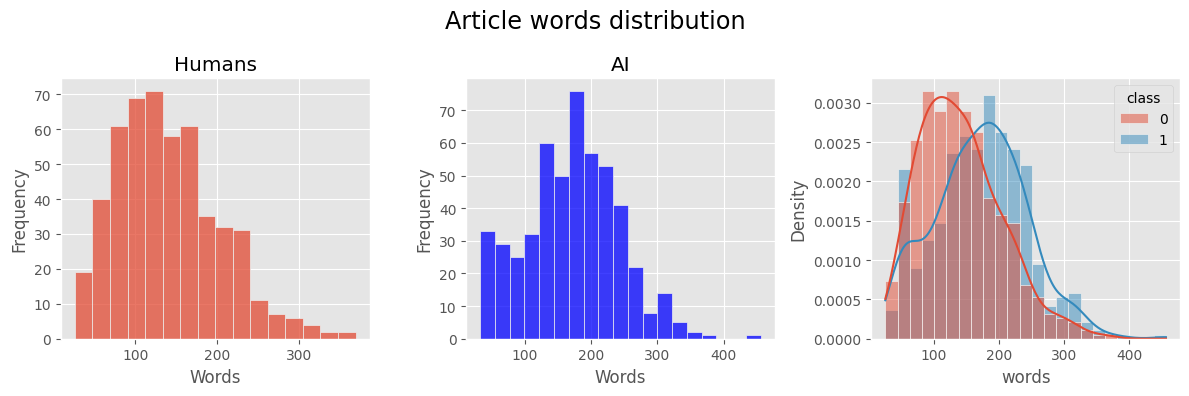

In [27]:
figg, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['class']==0], x = 'words', ax = axes[0])
fig_dist_human.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['class']==1], x = 'words', ax = axes[1], color='blue')
fig_dist_ai.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
sns.histplot(data = data, x = 'words', hue='class', kde= True, stat = 'density', ax = axes[2]) 
figg.suptitle('Article words distribution', fontsize =  'xx-large')
plt.tight_layout()

# It is not the same as before, the x-axis is different! But of course they are similar because we are counting the words and the lenghts

#### Sentence Count

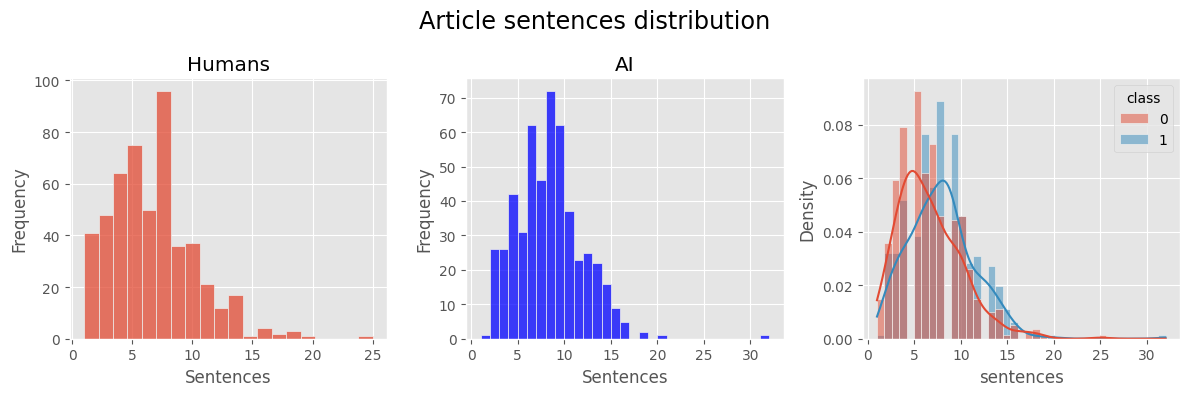

In [34]:
data['sentences'] = data['article'].map(lambda x: len(sent_tokenize(x)))
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_sentences_human = sns.histplot(data = data[data['class']==0], x = 'sentences', ax = axes[0])
fig_sentences_human.set(title = 'AI', xlabel='Sentences', ylabel= 'Frequency')
fig_sentences_ai = sns.histplot(data = data[data['class']==1], x = 'sentences', ax = axes[1], color='blue')
fig_sentences_ai.set(title = 'AI', xlabel='Sentences', ylabel= 'Frequency')
sns.histplot(data = data, x = 'sentences', hue='class', kde= True, stat = 'density', ax = axes[2]) 
fig.suptitle('Article sentences distribution', fontsize =  'xx-large')
plt.tight_layout()

# EDA --> Term frequency analysis

Steps I will follow:
1) Convert to lowercase
2) remove urls and html tags if any
3) Remove strange acceted characters if any
4) Remove punctuation
5) Remove extra white spaces 
6) Delet stop words

In [35]:
def lowering(text):
    return text.lower()

data['article_clean'] = data.article.apply(lowering)   

In [36]:
len(data[data.article_clean.str.contains('http')]) # there are 23 links, we can remove or not them, to be decided

23

In [37]:
def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

data['article_clean'] = data.article_clean.apply(remove_url)

In [38]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

data['article_clean'] = data.article_clean.apply(remove_accents)

In [39]:
def remove_punctuation(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

data['article_clean'] = data.article_clean.apply(remove_punctuation)

In [40]:
def remove_extra_spaces(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

data['article_clean'] = data.article_clean.apply(remove_extra_spaces)

In [41]:
# Spacy: 326 words to eliminate
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [42]:
# Delete stop words
def delete_stopwords(text):
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text

# Create new columns with new text and new length
data['article_clean'] = data.article_clean.apply(delete_stopwords)

In [63]:
def most_common_words(data):
    corpus = [word for i in data['article_clean'].str.split().values.tolist() for word in i]
    most_common = FreqDist(corpus).most_common(40)
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)   
    return dict(zip(words, frequency))

In [64]:
most_1_human = most_common_words(data[data['class']==0])
most_1_ai = most_common_words(data[data['class']==1])

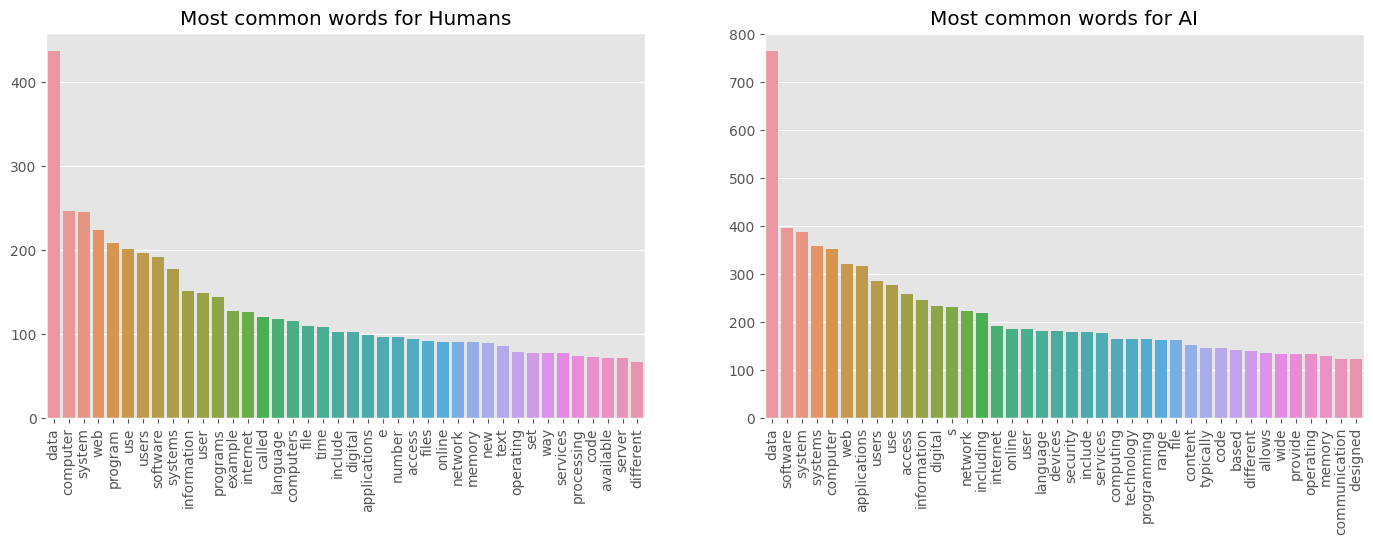

In [67]:
fig, axes = plt.subplots(1,2, figsize = (17,5))
sns.barplot(x = list(most_1_human.keys()), y = list(most_1_human.values()), ax = axes[0]).set(title="Most common words for Humans")
sns.barplot(x = list(most_1_ai.keys()), y = list(most_1_ai.values()), ax = axes[1]).set(title="Most common words for AI")
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.show()

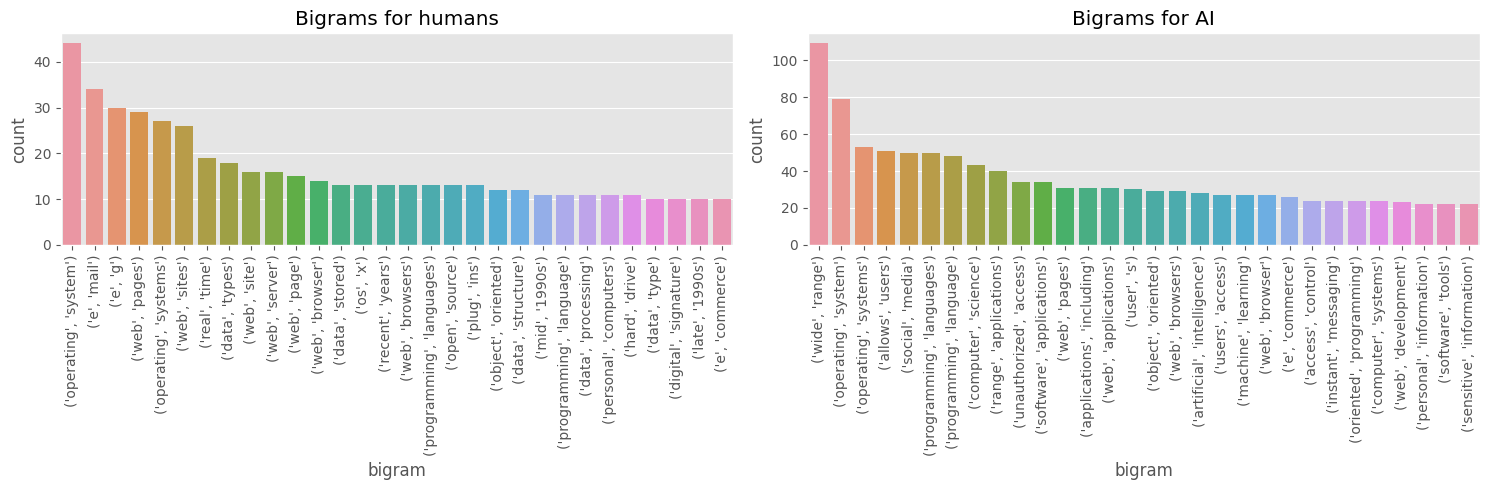

In [113]:
humans = data[data['class']==0]
corpus_humans = [word for i in humans.article_clean.str.split().values.tolist() for word in i]
bigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 2)).value_counts())
bigrams_df_h = bigrams_humans.reset_index()
bigrams_df_h.columns = ['bigram', 'count']

AI = data[data['class']==1]
corpus_AI = [word for i in AI.article_clean.str.split().values.tolist() for word in i]
bigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 2)).value_counts())
bigrams_df_AI = bigrams_AI.reset_index()
bigrams_df_AI.columns = ['bigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,5))
sns.barplot(bigrams_df_h.head(30), x = 'bigram', y ='count', ax=axes[0]).set(title = 'Bigrams for humans')
sns.barplot(bigrams_df_AI.head(30), x = 'bigram', y ='count', ax=axes[1]).set(title = 'Bigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

# Look! AI has very high frequences while humans at max 40 but I still need to fix tha data :)

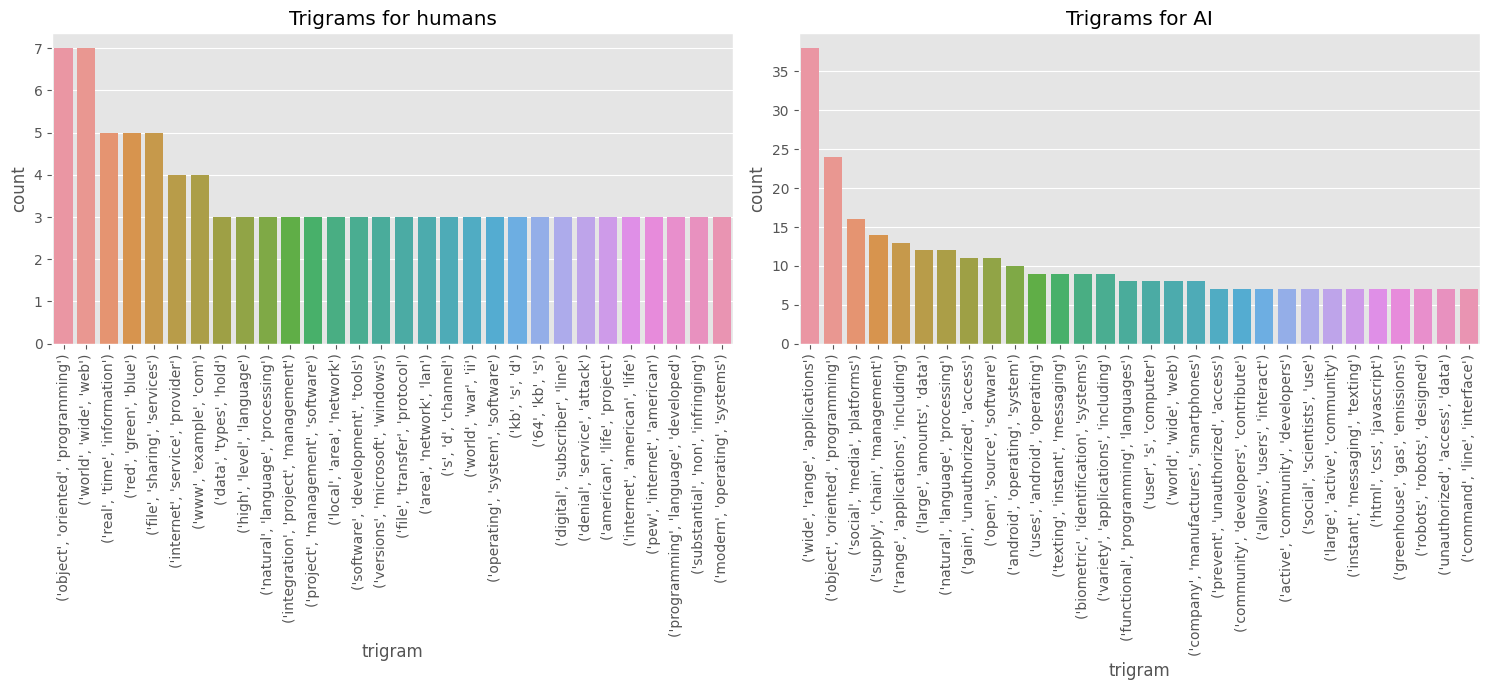

In [116]:
trigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 3)).value_counts())
trigrams_df_h = trigrams_humans.reset_index()
trigrams_df_h.columns = ['trigram', 'count']

trigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 3)).value_counts())
trigrams_df_AI = trigrams_AI.reset_index()
trigrams_df_AI.columns = ['trigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,7))
sns.barplot(trigrams_df_h.head(30), x = 'trigram', y ='count', ax=axes[0]).set(title = 'Trigrams for humans')
sns.barplot(trigrams_df_AI.head(30), x = 'trigram', y ='count', ax=axes[1]).set(title = 'Trigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()